In [134]:
import os
os.chdir('../quafing/')
print(f"Working directory: {os.getcwd()}")
import quafing as q


import random
import numpy as np
from scipy.stats import mode

from sklearn.feature_selection import mutual_info_regression

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt


plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

Working directory: /Users/charlesdupont/Desktop/Thesis/code/quafing


In [2]:
def load_data(path):
    """
    Loads .dta file using provided path.
    """
    return pd.read_stata(path, convert_categoricals=False)


def add_missing_hhids(all_hhids, df):
    """
    Adds empty rows for hhids missing from df.
    df must already have an "hhid" column!
    """
    missing = set(unique_hhids) - set(df["hhid"].unique())
    missing_dict = {"hhid":list(missing)}
    for col in df.columns:
        if col != "hhid":
            missing_dict[col] = [np.nan]*len(missing)
    missing_df = pd.DataFrame.from_dict(missing_dict)
    return pd.concat([df, missing_df])


def column_selection(df, keep=None, remove=None):
    """
    Performs column selection on dataframe.
    Args:
        no_change: boolean indicating whether to keep all columns
        keep: list of columns to keep
        remove: list of columns to remove
    Returns:
        updated dataframe
    """
    if keep:
        return df[keep]
    elif remove:
        return df.loc[:, ~df.columns.isin(remove)]
    else:
        return df

In [3]:
DATA_DIR = "../../BCCASII/"
DATA_SUBDIR = "Household/"

In [4]:
PROCESSED_DFS  = []
ADAPTATION_DFS = []

## A: Location and identification detail

In [5]:
filename = "001_mod_a.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [6]:
# keep household ID, agro-ecological zone
processed = column_selection(df, keep=["hhid", "ezcode"])

# construct community code from union, thana, district codes
processed["community_code"] = df["ucode"].astype(str) + "_" + \
                              df["tcode"].astype(str) + "_" + \
                              df["dcode"].astype(str)

In [7]:
PROCESSED_DFS.append(processed)

In [8]:
unique_hhids = df["hhid"].unique()

## B: Household composition and education

In [9]:
filename = "002_mod_b.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [10]:
g = df.groupby("hhid").count()

# household size
processed = pd.DataFrame.from_dict({"household_size":g["mid"]})

# household id
processed["hhid"] = processed.index

# ratio male, female
males = {}
females = {}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    m = sum(household["b01"]==1)
    f = sum(household["b01"]==2)
    s = max(1, m+f)
    males[hhid] = m/s
    females[hhid] = f/s
processed = processed.join(pd.DataFrame.from_dict({"ratio_male":males}))
processed = processed.join(pd.DataFrame.from_dict({"ratio_female":females}))

# number of children
num_children = {}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    c = sum(household["b03"] < 18)
    num_children[hhid] = c
processed = processed.join(pd.DataFrame.from_dict({"number_children":num_children}))

# highest level of education
education_ordering = [99, 66, 67, 68, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 22, 10, 33, 12, 15, 16, 17]
max_education = {}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    education_levels = [education_ordering.index(x)
                        for x in [x for x in list(household["b06"]) if not np.isnan(x)]]
    if len(education_levels):
        max_education[hhid] = max(education_levels)
    else:
        max_education[hhid] = -1
processed = processed.join(pd.DataFrame.from_dict({"highest_education":max_education}))

# highest level of literacy
literacy_ordering = [1, 2, 3, 4]
max_literacy = {}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    literacy_labels = [literacy_ordering.index(x)
                       for x in [x for x in list(household["b05"]) if not np.isnan(x)]]
    if len(literacy_labels):
        max_literacy[hhid] = max(literacy_labels)
    else:
        max_literacy[hhid] = -1
processed = processed.join(pd.DataFrame.from_dict({"highest_literacy":max_literacy}))

# primary occupation categories
# categories = {
#     "day_labor": [1,2,3],
#     "self_employ_farm": [4,5,6,7,8],
#     "self_employ_non_farm": [9],
#     "low_income_profession": [10,11,12,13],
#     "mechanic": [14,15],
#     "other": [16, 17, 18, 19],
#     "non_earning": [20,21,22,23,24,25,26]
# }

# for c, c_list in categories.items():
#     c_dict = {hhid:0 for hhid in unique_hhids}
#     for hhid in unique_hhids:
#         household = df.loc[df.hhid==hhid]
#         primary_occupation_labels = list(household["b08_1"])
#         for item in c_list:
#             if item in primary_occupation_labels:
#                 c_dict[hhid] += 1
#     processed = processed.join(pd.DataFrame.from_dict({c:c_dict}))

In [11]:
PROCESSED_DFS.append(processed)

## C: Roster of land and water bodies owned or under operation

In [12]:
filename = "003_mod_c.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [13]:
g = df.groupby("hhid")

# total land area
processed = pd.DataFrame.from_dict({"total_land_size":dict(g.sum()["c102"])})

# household id
processed["hhid"] = processed.index

# total value per month
processed = processed.join(pd.DataFrame.from_dict({"total_land_value_per_month":
                                                   dict(g.sum()["c113"])}))

# min land acquisition year
processed = processed.join(pd.DataFrame.from_dict({"min_land_acquisition_year":
                                                   dict(g.min()["c111"])}))

# max land acquisition year
processed = processed.join(pd.DataFrame.from_dict({"max_land_acquisition_year":
                                                   dict(g.max()["c111"])}))

# mean land acquisition year
processed = processed.join(pd.DataFrame.from_dict({"mean_land_acquisition_year":
                                                   dict(round(g.mean()["c111"]))}))

# most common answer from (plot type, soil type, operational status of land, acquisition means of land)
categories = {
    ("plot_type", "c101"): [i for i in range(1, 10)],
    ("soil_type", "c105"): [i for i in range(1, 6)],
    ("land_operational_status", "c107"): [i for i in range(1, 11)],
    ("land_acquisition_means", "c110"): [i for i in range(1, 8)],
}

for c, c_list in categories.items():
    c_dict = {hhid:0 for hhid in unique_hhids}
    c, col = c
    for hhid in unique_hhids:
        household = df.loc[df.hhid==hhid]
        labels = [x for x in list(household[col]) if not np.isnan(x)]
        if labels:
            c_dict[hhid] = mode(labels)[0][0]
        else:
            c_dict[hhid] = -1
    processed = processed.join(pd.DataFrame.from_dict({c:c_dict}))

In [14]:
PROCESSED_DFS.append(processed)

## F1: Livestock and poultry

In [15]:
filename = "004_mod_f1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [16]:
# # household id
# processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})

# categories = {
#     "cattle_buffalo":1,
#     "goat_sheep":2,
#     "pigs":3,
#     "chidken_duck":4
# }

# cols = [("count_2011", "f102"), ("value_2011", "f103"), 
#         ("count_now", "f104"), ("value_now", "f105"), ("total_selling_value", "f117")]   

# results = {hhid:{} for hhid in unique_hhids}
# for hhid in unique_hhids:
#     household = df.loc[df.hhid==hhid]
#     for c, number in categories.items():
#         if number not in list(household["f101"]):
#             # TODO: handle missing value!
#             for l, _ in cols:
#                 results[hhid][c+"_"+l] = np.nan
#         else:
#             for l, col in cols:
#                 value = household.loc[household["f101"]==number][col].iloc[0]
#                 # TODO: handle missing value here!
#                 if np.isnan(value):
#                     results[hhid][c+"_"+l] = np.nan
#                 else:
#                     results[hhid][c+"_"+l] = value
                    
# for column in results[1]:
#     processed[column] = [results[hhid][column] for hhid in results]

In [17]:
# household id
processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})

cols = [("count_2011", "f102"), ("value_2011", "f103"), 
        ("count_now", "f104"), ("value_now", "f105"), ("total_selling_value", "f117")]   

results = {hhid:{} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    for c, col in cols:
        relevant = [x for x in household[col] if not np.isnan(x)]
        if len(relevant):
            results[hhid][c] = sum(relevant)
        else:
            results[hhid][c] = np.nan
                    
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]

In [18]:
PROCESSED_DFS.append(processed)

## F3: Expenditure for livestock, Poultry/Duckery Production Last 12 Months

In [19]:
filename = "005_mod_f3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [20]:
df["f306"] = df["f306_1"].fillna(0) + df["f306_2"].fillna(0)
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["f302", "f303", "f306", "f307"])
processed["hhid"] = processed.index

In [21]:
PROCESSED_DFS.append(processed)

## G1: Credit obtained

In [22]:
filename = "006_mod_g.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [23]:
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["g07", "g10", "g16", "g18"])
processed["hhid"] = processed.index

In [24]:
PROCESSED_DFS.append(processed)

## G2: Repayment and utilization of Loan

In [25]:
# TODO

## H: Household Assets

In [26]:
filename = "007_mod_h.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [27]:
# household id
processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})

# total value per household asset category
categories = {
    "value_consumable_durables":[i for i in range(1, 12)],
    "value_transport":[i for i in range(12, 16)],
    "value_livestock_poultry":[i for i in range(16, 20)],
    "value_agricultural_equipments":[i for i in range(20,29)],
    "value_other":[29]
}

results = {hhid:{} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    for c in categories:
        category_assets = household.loc[household["asset"].isin(categories[c])]
        if len(category_assets):
            results[hhid][c] = category_assets["h06"].sum()
        else:
            results[hhid][c] = 0

for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]

In [28]:
PROCESSED_DFS.append(processed)

## H1: Assets: Sales of Assets and Change in Ownership

In [29]:
filename = "008_mod_h1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [30]:
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["h108"])
processed["hhid"] = processed.index

In [31]:
PROCESSED_DFS.append(processed)

## I: Food Consumption: Purchases, Home Production, and Other Sources

In [32]:
filename = "009_mod_i.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [33]:
food_categories = {
    "food_cereals":np.arange(1,10),
    "food_pulses":np.arange(11,18),
    "food_edible_oil":np.arange(21,25),
    "food_vegetables":np.arange(31,56),
    "food_leafy_vegetables":np.arange(61,75),
    "food_meat_eggs_milk":np.arange(81,88),
    "food_fruits":np.arange(91,113),
    "food_fish_large":np.arange(121,132),
    "food_fish_small":np.arange(141,149),
    "food_spices":np.arange(151,161),
    "food_other":np.arange(171,177),
    "food_drinks":np.arange(181,184),
    "food_other_outside_home":np.arange(201,213)
}

results = {hhid:{} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    for c, fcodes in food_categories.items():
        relevant_rows = household.loc[household["fcode"].isin(fcodes)]
        
        if len(relevant_rows):
            values = [x for x in list(relevant_rows["i07"]) if not np.isnan(x)]
            if len(values):
                results[hhid]["value_"+c] = sum(values)
            else:
                results[hhid]["value_"+c] = np.nan
            weights = [x for x in list(relevant_rows["i04"]) if not np.isnan(x)]
            if len(weights):
                results[hhid]["weight_"+c] = sum(weights)
            else:
                results[hhid]["weight_"+c] = np.nan
        else:
            results[hhid]["value_"+c] = np.nan
            results[hhid]["weight_"+c] = np.nan
            
            
processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]

In [34]:
PROCESSED_DFS.append(processed)

## J1, J2: Non-food Expenditure

In [35]:
filename = "010_mod_j.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [36]:
non_food_categories = {
    "rent_expenses":[1,2],
    "fuel_expenses":[3,4,5,6],
    "local_transport_expenses":[7,8],
    "miscellaneous_expenses":[9,10,11,12,13,29,30,31,32,54,55],
    "health_expenses":[14,15,16],
    "communication_expenses":[17,18],
    "personal_items_expenses":np.arange(19,25),
    "entertainment_expenses":[25,26],
    "non_local_travel_expenses":[27,28],
    "clothing_expenses":np.arange(33,39),
    "furniture_household_expenses":np.arange(39,49),
    "utilities_taxes_fees":np.arange(49,54),
    "family_events_expenses":[56,57],
    "wedding_costs_bride":np.arange(59,63),
    "wedding_costs_groom":np.arange(63,67),
    "education_expenses":np.arange(67,73),
    "vehicle_expenses":np.arange(73,77)
}

results = {hhid:{} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    for c, nfcodes in non_food_categories.items():
        relevant_rows = household.loc[household["nfcode"].isin(nfcodes)]
        if len(relevant_rows) == 0:        
            for col in ["j02_1", "j02_2", "j03_1", "j03_2"]:
                results[hhid][col+"_"+c] = np.nan
        else:
            for col in ["j02_1", "j02_2", "j03_1", "j03_2"]:
                items = [x for x in list(relevant_rows[col]) if not np.isnan(x)]
                if len(items):
                    results[hhid][col+"_"+c] = sum(items)
                else:
                    results[hhid][col+"_"+c] = np.nan

processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]

In [37]:
PROCESSED_DFS.append(processed)

## K: Housing, Source of Water and sanitation

In [38]:
filename = "011_mod_k.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [39]:
processed = column_selection(df, keep=["hhid", "k01", "k02", "k03", "k03_1", 
                                       "k04", "k05", "k05_1", "k06", "k07", "k10"])

In [40]:
PROCESSED_DFS.append(processed)

## L : Weather events adversely affected the household or the farming

In [41]:
filename = "012_mod_l.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [42]:
calamity_numbers = [i for i in range(1, 13)]

results = {hhid:{} for hhid in unique_hhids}

for hhid in unique_hhids:
    household = df.loc[df.hhid == hhid]
    nums = list(household["l01"])
    for n in calamity_numbers:
        # TODO: missing values!
        if n not in nums:
            results[hhid]["calamity_"+str(n)] = 0
        else:
            if int(household.loc[household["l01"]==n]["l02"]) == 1:
                results[hhid]["calamity_"+str(n)] = 1
            else:
                results[hhid]["calamity_"+str(n)] = 0       

processed = pd.DataFrame()
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]
    
processed["hhid"] = unique_hhids

In [43]:
PROCESSED_DFS.append(processed)

## L1: Weather events adversely affected the household or the farming cope

In [44]:
filename = "013_mod_l1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [45]:
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["l1_05"])
processed = processed.rename(columns={"l1_05":"weather_events_damage"})
processed["hhid"] = processed.index

In [46]:
PROCESSED_DFS.append(processed)

## L2: Shocks

In [47]:
filename = "014_mod_l2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [48]:
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["l2_06"])
processed["hhid"] = processed.index

In [49]:
PROCESSED_DFS.append(processed)

## L3: Positive Economic Events

In [50]:
filename = "015_mod_l3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [51]:
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["l3_06"])
processed["hhid"] = processed.index

In [52]:
PROCESSED_DFS.append(processed)

## M: Agricultural extension

In [53]:
filename = "017_mod_m.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [54]:
processed = column_selection(df)

In [55]:
PROCESSED_DFS.append(processed)

## Q: Perceptions of Climate Change

In [56]:
filename = "018_mod_q.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [57]:
processed = column_selection(df)

In [58]:
PROCESSED_DFS.append(processed)

## O: Changes in farming practices due to climate change

In [59]:
filename = "019_mod_o.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [60]:
keep = ["hhid"] + ["o0"+str(i)+"_1" for i in range(2, 9)] + ["o09"] + \
       ["o"+str(i) for i in range(10, 23)] + ["o"+str(i)+"_1" for i in range(23, 29)] + ["o29"]

processed = column_selection(df, keep=keep)

In [61]:
PROCESSED_DFS.append(processed)

In [62]:
ADAPTATION_DFS.append(processed)

## O1: Any integration about Livestock/Poultry

In [63]:
filename = "020_mod_o1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [64]:
keep = ["hhid"] + ["o1_01_"+str(i) for i in range(1, 10)]
processed = column_selection(df, keep=keep)

In [65]:
PROCESSED_DFS.append(processed)

In [66]:
ADAPTATION_DFS.append(processed)

## O2: Constraints to adaptation

In [67]:
filename = "021_mod_o2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [68]:
max_len = 0
for hhid in unique_hhids:
    max_len = max(max_len, len(df.loc[df.hhid==hhid]))

results = {hhid:{} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    idx = 0
    for _, row in household.iterrows():
        results[hhid][f"constraints_{idx}_measure"] = row["o2_01"]
        severity = [x for x in row[["o2_03_1", "o2_03_2", "o2_03_3", "o2_03_4", "o2_03_5"]] if not np.isnan(x)]
        if len(severity):
            for i in range(5):
                if i in severity:
                    most_severe = severity.index(i) + 1
                    results[hhid][f"constraints_{idx}_constraint"] = row[f'o2_02_{most_severe}']
                    break
        else:
            results[hhid][f"constraints_{idx}_constraint"] = np.nan
        
        idx += 1
    
    while idx < max_len:
        results[hhid][f"constraints_{idx}_measure"] = np.nan
        results[hhid][f"constraints_{idx}_constraint"] = np.nan
        idx += 1

In [69]:
PROCESSED_DFS.append(processed)

## R1: Information of group based approach

In [71]:
filename = "022_mod_r1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [72]:
groups = np.arange(1, 19)

results = {hhid:{} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    for g in groups:
        g_row = household.loc[household["r1_01"]==g]
        if len(g_row):
            membership_values = list(g_row["r1_02"])
            if 1 in membership_values:
                results[hhid][f"group_{g}_membership"] = 1
            else:
                results[hhid][f"group_{g}_membership"] = 0
        else:
            results[hhid][f"group_{g}_membership"] = 0
            
processed = pd.DataFrame()
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]
    
processed["hhid"] = unique_hhids

In [73]:
PROCESSED_DFS.append(processed)

## R2: Group activity related information

In [74]:
filename = "023_mod_r2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [75]:
keep = ["hhid"]
keep += [f"r2_15_{i}" for i in range(1,5)] + [f"r2_16_{i}" for i in range(1,5)]
for j in range(17, 24):
    keep += [f"r2_{j}_{i}_1" for i in range(1,5)]
processed = column_selection(df, keep=keep)

## R3: Network

In [76]:
filename = "024_mod_r3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [77]:
processed = column_selection(df, remove=["r3_01_1", "r3_01_2"])

In [78]:
PROCESSED_DFS.append(processed)

## R4: Trust and Solidarity

In [79]:
filename = "025_mod_r4.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [80]:
processed = column_selection(df, remove=["r4_01_1", "r4_01_2"])

In [81]:
PROCESSED_DFS.append(processed)

## R5: Economic setbacks

In [82]:
filename = "026_mod_r5.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [83]:
results = {hhid:0 for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    if 1 in list(household["r5"]):
        results[hhid] = 1
        
processed = pd.DataFrame.from_dict({"r5":results})
processed["hhid"] = processed.index

In [84]:
PROCESSED_DFS.append(processed)

## R6: Collective Action and Cooperation and Sociability

In [85]:
filename = "027_mod_r6.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [86]:
processed = column_selection(df, remove=["r6_01_1", "r6_01_2"])

In [87]:
PROCESSED_DFS.append(processed)

## R7: Information and Communication

In [88]:
filename = "028_mod_r7.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [89]:
processed = column_selection(df, remove=["r7_01_1", "r7_01_2"])

In [90]:
PROCESSED_DFS.append(processed)

## R8: Production and climate Information

In [91]:
filename = "029_mod_r8.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [92]:
keep = ["hhid", "r8_02_1", "r8_02_2", "r8_06_1", "r8_06_2", "r8_14_1", "r8_14_2"]
processed = column_selection(df, keep=keep)

In [93]:
PROCESSED_DFS.append(processed)

## R9: Production and climate Information

In [94]:
filename = "030_mod_r9.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [95]:
keep = ["hhid", "r9_02_1", "r9_02_2", "r9_09_1", "r9_09_2"]
processed = column_selection(df, keep=keep)

In [96]:
PROCESSED_DFS.append(processed)

## S: Empowerment and Political Action

In [97]:
filename = "031_mod_s.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [98]:
processed = column_selection(df, remove=["s_01_1", "s_01_2"])

In [99]:
PROCESSED_DFS.append(processed)

## T: Employment

In [100]:
filename = "032_mod_t.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [101]:
job_categories = {
    "job_wage_labor":np.arange(1,12),
    "job_salaried_worker":np.arange(12,22),
    "job_self_employment":np.arange(22,48),
    "job_trader":np.arange(50,55),
    "job_production":np.arange(55,58),
    "job_livestock_poultry_service":np.arange(58,64),
    "job_farming":np.arange(64,73)
}

results = {hhid:{c:0 for c in job_categories} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    relevant = list(household["t05"])
    for c, numbers in job_categories.items():
        for n in numbers:
            if n in relevant:
                results[hhid][c] += 1
            
processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})        
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]

In [102]:
PROCESSED_DFS.append(processed)

## U: Time use of male and female members in the household

In [103]:
# TODO: discard?

## V: Anthropometry

In [104]:
# TODO: discard?

# Combine processed dataframes

In [101]:
# maintain list of all the processed dataframes
# make sure all dataframes have one row per household id
# add empty rows for missing household ids where necessary
# mind the treatment of MISSING VALUES!
    # do we really want to impute "0" when no information is present?
    # just leave as empty
        # then if we see a household with many empty fields, or a feature with mostly empty values,
        # we remove it
# combine all the dataframes into one dataframe (each hhid is a single feature vector/row)

# Mutual Information Regression

In [129]:
num_changes = {hhid:0 for hhid in unique_hhids}
for DF in ADAPTATION_DFS:
    for hhid in unique_hhids:
        hh = DF.loc[DF.hhid==hhid]
        if len(hh):
            ignore_hhid_col = hh.loc[:, ~hh.columns.isin(['hhid'])]
            num_changes[hhid] += sum(np.array(ignore_hhid_col.iloc[0]==1))

In [130]:
mutual_info = {}

for i, DF in enumerate(PROCESSED_DFS):
    for col in DF.columns:
        if col not in ["hhid", "community_code"]:
            X = {}
            for hhid in DF.hhid:
                if hhid in num_changes:
                    val = list(DF.loc[DF.hhid==hhid][col])[0]
                    if not np.isnan(val):
                        X[hhid] = val
            
            sorted_keys = sorted(X.keys())
            X = np.array([X[k] for k in sorted_keys]).reshape(-1,1)
            y = np.array([num_changes[k] for k in sorted_keys])
            try:
                mutual_info[col] = mutual_info_regression(X,y)[0]
            except:
                mutual_info[col] = -1
            
    print(i/len(PROCESSED_DFS))

0.0
0.03333333333333333
0.06666666666666667
0.1
0.13333333333333333
0.16666666666666666
0.2
0.23333333333333334
0.26666666666666666
0.3
0.3333333333333333
0.36666666666666664
0.4
0.43333333333333335
0.4666666666666667
0.5
0.5333333333333333
0.5666666666666667
0.6
0.6333333333333333
0.6666666666666666
0.7
0.7333333333333333
0.7666666666666667
0.8
0.8333333333333334
0.8666666666666667
0.9
0.9333333333333333
0.9666666666666667


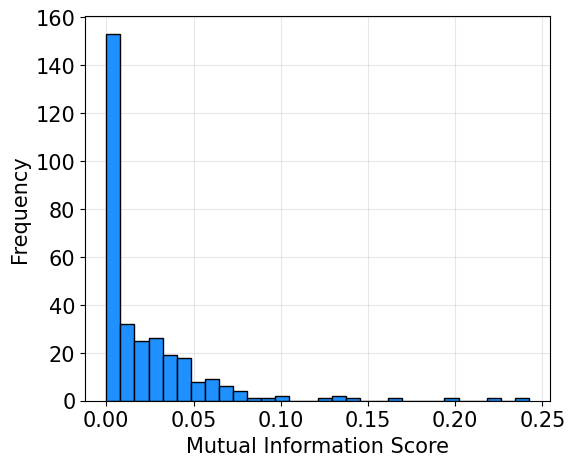

In [158]:
valz = []
for col, val in mutual_info.items():
    if col[0] != "o" and val != -1:
        valz.append(val)
        
plt.hist(valz, color="dodgerblue", edgecolor="k", bins=30)
plt.xlabel("Mutual Information Score")
plt.ylabel("Frequency")
plt.show()

In [159]:
k = sorted(mutual_info, key=lambda x: mutual_info[x], reverse=True)
k = [item for item in k if item[0] != "o"]

pairs = []
for item in k:
    pairs.append((item, mutual_info[item]))
    
pairs[:15]

[('j03_2_miscellaneous_expenses', 0.2422801942209829),
 ('j02_1_vehicle_expenses', 0.22404994210686602),
 ('r6_04_2_2', 0.19943450063543144),
 ('r6_03_1_3', 0.161805842015585),
 ('r7_11_1_3', 0.1418564365763988),
 ('r7_11_1_2', 0.13461671782986118),
 ('j03_2_family_events_expenses', 0.13055555555555576),
 ('r7_07_2_3', 0.12615182269547232),
 ('r7_06_2_3', 0.10387365663563619),
 ('job_farming', 0.09939711695271258),
 ('weight_food_drinks', 0.0916661736844584),
 ('s_06_3_2', 0.08231736077019924),
 ('value_food_other', 0.08024871898797814),
 ('j03_1_health_expenses', 0.07870370370370372),
 ('m01', 0.07748945845422206)]